## 2. Model SIR Mean Counts $S(t, \alpha, \beta)$ and $I(t, \alpha, \beta)$
Created: Mar 18, 2024 HBP and Hassan Mahamat Nil, Johannesburg, South Africa<br>

### Introduction 

This notebook attempts to model the mean counts $S(t, \alpha, \beta)$ and $I(t, \alpha, \beta)$ from simulated epidemics. The training data are a random sequence of 5-tuples, $(\alpha, \beta, t, s, i)$. We shall use the (scaled) counts $s$ and $i$ as **targets** and $\alpha, \beta, t$ as **inputs**.

In [3]:
BASE = '../../01_sbi_tutorial/'

import os, sys

sys.path.append(f'{BASE:s}/src')
sys.path.append('../')

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

import SIR_dnnutil as ut
from SIR_genutil import SIRdata

%matplotlib inline

device: cpu


In [4]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 217
rnd  = np.random.RandomState(seed)

### Load data

__Note__: The $\alpha$ and $\beta$ parameters have been scaled so that they are of $\cal{O}(1)$. Therefore, no further transformation is needed.

In [6]:
print('SIRdata')
data = SIRdata
data.alpha_min,  data.alpha_max = 0.10, 0.90
data.beta_min,   data.beta_max  = 0.25, 0.65
print(data)
print()

datafile = f'../data/traindata_110k.csv.gz'
print('loading %s' % datafile)
df = pd.read_csv(datafile)
print('number of rows:', len(df))

# Scale counts and times

df.t /= data.tmax

total = data.S0 + data.I0 + data.R0
df.s /= total
df.i /= total

df[:5]

SIRdata
 D           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 I0          : 3
 O           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 R0          : 0
 S0          : 763
 T           : [ 0  2  3  4  5  6  7  8  9 10 11 12 13]
 alpha0      : 0.465
 alpha_bins  : 16
 alpha_max   : 0.9
 alpha_min   : 0.1
 alpha_scale : 1.0
 beta0       : 0.00237
 beta_bins   : 16
 beta_max    : 0.65
 beta_min    : 0.25
 beta_scale  : 0.005
 model       : SIR
 scale       : 50
 tmax        : 14.0
 tmin        : 0.0


loading ../data/traindata_110k.csv.gz
number of rows: 110000


,alpha,beta,t,s,i
0,0.213605,0.555996,0.071429,0.981723,0.016971
1,0.035917,0.609252,0.464286,0.000000,0.896867
2,0.901360,0.650791,0.142857,0.745431,0.184073
3,0.406070,0.219739,0.321429,0.869452,0.065274
4,0.039018,0.566040,0.678571,0.000000,0.779373


### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

In [7]:
# Fraction of the data assigned as test data and validation
tfraction = 5/110 # test fraction
vfraction = 5/110 # validation fraction
tdata     = df

SIRdata.alpha_bins = 10
SIRdata.beta_bins  = 10

# Split data into a part for training and a part for testing
train_data, valid_data, test_data = ut.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:        100000
validation set size:     5000
test set size:           5000


### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined by

\begin{align}
R_M(\theta) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\mathbf{x}_m, \theta).
\end{align*}

The empirical risk $R_M$ approximates the __risk functional__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x} .
\end{align}

The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

We use the __quadratic loss__

\begin{align}
    L(t, f) &= (t - f)^2 .
\end{align}

### Define model $f(\alpha, \beta, t; \omega)$

For simple models, it is sufficient to use the __Sequential__ class.

In [14]:
%%writefile ../models/SIR_soln_100k.py

name     = 'SIR_soln_100k'
features = ['alpha', 'beta', 't']
target   = ['s', 'i']
nodes    =  20

import torch
import torch.nn as nn

model = nn.Sequential(nn.Linear(len(features), nodes), nn.ReLU(),
                      nn.Linear(nodes, nodes), nn.ReLU(),
                      nn.Linear(nodes, nodes), nn.ReLU(),
                      nn.Linear(nodes, nodes), nn.ReLU(),
                      nn.Linear(nodes, 2))

Overwriting ../models/SIR_soln_100k.py


In [15]:
import models.SIR_soln_100k as NN
importlib.reload(NN)
name     = NN.name
model    = NN.model
features = NN.features
target   = NN.target

modelfile  = '../models/%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d' % ut.number_of_parameters(model))

SIR_soln_100k
Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=2, bias=True)
)
number of parameters: 1382


### Train!

In [16]:
traces = ([], [], [])
traces_step = 100

Iteration vs average loss
iteration train-set valid-set
0        0 0.2681490 0.2676859
100      100 0.2305571 0.2301237
200      200 0.1950085 0.1946160
300      300 0.1566512 0.1563218
400      400 0.1324120 0.1320720
182300200 0.0096501 0.0093678    182200:     82200/0.00937410/   100000

stopping early!



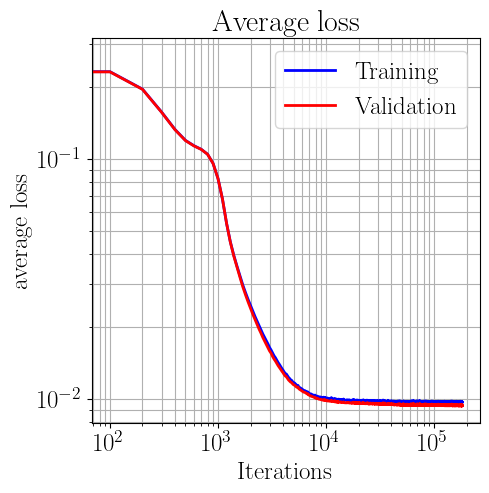

In [17]:
n_batch       = 100
n_iterations  = 10000000
early_stopping= 100000
learning_rate = 1.e-4

av_loss = ut.average_quadratic_loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

traces = ut.train(model, optimizer, 
                  modelfile, early_stopping,
                  av_loss,
                  ut.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

ut.plot_average_loss(traces)

### Load trained model

In [13]:
Load_model = True
print('load model: %s' % modelfile)

if Load_model:
    modeldict = torch.load(modelfile)
    NN.model.load_state_dict(modeldict)


def dnn(alpha, beta, t):
    X = np.array([alpha, beta, t]).T
    inputs = torch.Tensor(X)
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    Y = model(inputs).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

load model: ../models/SIR_dnn_cdf_100k.dict
